In [1]:
import os
import time
import uuid
import cv2
import time
from djitellopy import tello

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

In [3]:
import random
import re

In [4]:
import albumentations as alb

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, Rescaling, Input, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [52]:
raw_img_base_path = '../../data/raw'

# Generate data

## Gather images

_Done in drone main.py_

## Label images

_Use label me to draw boxes around all hands and mark with class name (e.g. no_hand, fist etc.)_

In [7]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/philipwitte/.labelmerc


## Partition new image data 

In [469]:
new_img_base_path = os.path.join('../..', 'data', 'new')

In [470]:
# Put images into regarding folders (randomly)
# First create list of all file_names
file_list = []
for folder in os.listdir(os.path.join(new_img_base_path, 'not_allocated')):
    if folder != 'labels' and folder[0] != '.':
        for file in os.listdir(os.path.join(new_img_base_path, 'not_allocated', folder)):
            if re.findall(r'\.jpg', file):
                file_list.append([folder, file])
len(file_list)

0

In [471]:
# ... then define sizes of datasets...
train_size = int(0.7 * len(file_list))
val_size = int(0.15 * len(file_list))
test_size = len(file_list) - train_size - val_size

train_size, val_size, test_size

(0, 0, 0)

In [472]:
# ...and finally move files randomly into target folders
for partition, sample_size in zip(['train', 'val', 'test'], [train_size, val_size, test_size]):
    selected_images = random.sample(file_list, sample_size)
    file_list = [image for image in file_list if image not in selected_images]
    for image in selected_images:
        os.rename(os.path.join(new_img_base_path, 'not_allocated', image[0], image[1]), 
                  os.path.join(new_img_base_path, 'images', partition, image[1]))

In [473]:
# ...labels can be shifted accordingly
count_no_labels = 0
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join(new_img_base_path, 'images', partition)):
        label_name = image[:-3] + 'json'
        try: 
            os.rename(os.path.join(new_img_base_path, 'not_allocated', 'labels', label_name), 
                  os.path.join(new_img_base_path, 'labels', partition, label_name))
        except:
            count_no_labels += 1
print(f'In total {count_no_labels} images without label info.')

In total 0 images without label info.


In [475]:
# ... now shift images and labels into regarding 'raw'-folders
for partition in ['train', 'val', 'test']:
    # Move images
    for image in os.listdir(os.path.join(new_img_base_path, 'images', partition)):
        os.rename(os.path.join(new_img_base_path, 'images', partition, image), 
                  os.path.join(raw_img_base_path, 'images', partition, image))
    # Move labels
    for label in os.listdir(os.path.join(new_img_base_path, 'labels', partition)):
        os.rename(os.path.join(new_img_base_path, 'labels', partition, label), 
                  os.path.join(raw_img_base_path, 'labels', partition, label))

In [615]:
# And delete empty folders
for folder in os.listdir(os.path.join(new_img_base_path, 'not_allocated')):
    if folder != 'labels':
        for file in os.listdir(os.path.join(new_img_base_path, 'not_allocated', folder)):
            if file[0] == '.':
                os.remove(os.path.join(new_img_base_path, 'not_allocated', folder, file))
        os.rmdir(os.path.join(new_img_base_path, 'not_allocated',folder))

## Review images

In [476]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [515]:
X_train = []
images_path = os.path.join(raw_img_base_path, 'images', 'train')

for file in os.listdir(images_path):
    if file[0] != '.': # Filter out 'DS_Store'-objects       
        # load the image
        img = load_img(os.path.join(images_path, file))
        # convert it to an array
        img_array = np.array(img)
        # append the array to X
        X_train.append(img_array)
        
#X_train = np.array(X_train)

In [520]:
type(X_train)

list

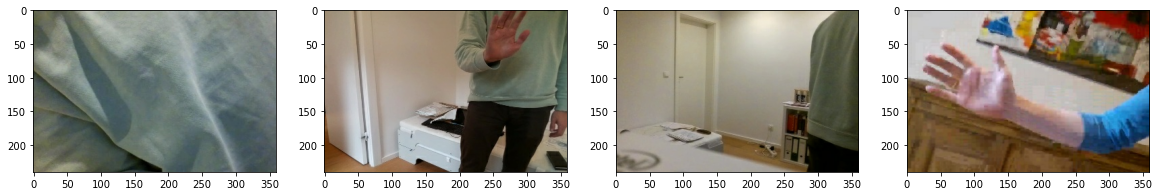

In [526]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(X_train[1:32:8]):
    ax[idx].imshow(image)
plt.show()

# Perform image augmentation

## Create augmentor with albumentation

In [527]:
augmentor = alb.Compose([alb.RandomBrightnessContrast((-0.2, 0.4), p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.augmentations.geometric.transforms.Affine(
                             translate_percent=(-0.15, 0.15), 
                             rotate=(-5,5),
                             mode=cv2.BORDER_CONSTANT,p=0.2)],
                         bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## Use augmentor for a single image

In [528]:
img = cv2.imread(os.path.join(raw_img_base_path, 'images', 'train', '1c6bc3e6-e0f4-11ec-ae3a-8a15287fd426.jpg'),)

In [529]:
with open(os.path.join(raw_img_base_path, 'labels', 'train', '1c6bc3e6-e0f4-11ec-ae3a-8a15287fd426.json'), 'r') as f:
    label = json.load(f)

In [530]:
type(label)

dict

In [531]:
label['shapes']

[{'label': 'straight_hand',
  'points': [[12.171052631578947, 8.868421052631579],
   [79.9342105263158, 88.47368421052632]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

In [532]:
class_label = label['shapes'][0]['label']
class_label

'straight_hand'

In [533]:
points = label['shapes'][0]['points']
points

[[12.171052631578947, 8.868421052631579],
 [79.9342105263158, 88.47368421052632]]

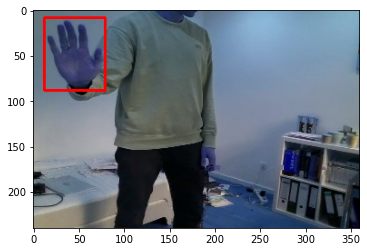

In [534]:
cv2.rectangle(img,
              tuple([int(i) for i in points[0]]),
              tuple([int(i) for i in points[1]]),
              (255, 0, 0), 2)

plt.imshow(img)

In [535]:
# Convert coordinates into a one-dimensional list
coords = []
for coord_list in points:
    for coord in coord_list:
        coords.append(coord)
coords

[12.171052631578947, 8.868421052631579, 79.9342105263158, 88.47368421052632]

In [536]:
# Convert into 'alubmentations' format, i.e. relative to img dimensions
coords = list(np.divide(coords, [360, 240, 360, 240]))
coords

[0.03380847953216374,
 0.03695175438596491,
 0.22203947368421054,
 0.368640350877193]

In [537]:
# Augment image using the defined augmentor
augmented = augmentor(image=img, bboxes=[coords], class_labels=['straight_hand'])

In [538]:
# Output is a dictionary
type(augmented)

dict

In [539]:
# Image, bbox and class labels are keys
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

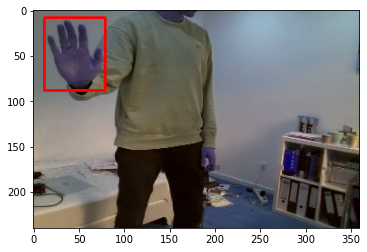

In [540]:
# Draw augmented image incl. bbox
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [360, 240]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [360, 240]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

## Perform augmentation and partition data

In [541]:
aug_img_base_path = "../../data/augmented"

In [542]:
for data_type in ['images', 'labels']:
    for partition in ['train', 'val', 'test']:
        for file in os.listdir(os.path.join(aug_img_base_path, data_type, partition)):
                    os.remove(os.path.join(aug_img_base_path, data_type, partition, file))

In [543]:
# Augment images and save in regarding folders augemneted/images and augmented/labels
for partition in ['train', 'val', 'test']:
    partition_dir = os.path.join(raw_img_base_path, 'images', partition)
    for image_name in os.listdir(partition_dir):
      
        # Load image
        image = cv2.imread(os.path.join(partition_dir, image_name))
        
        # In case no label is available, coordinates and class_label are predefined
        class_label = 'no_hand'
        coords = [0.4, 0.4, 0.6, 0.6] # x_max / y_max need to be > 0 for augmentor, later set to 0
        
        # Load label (if exists) and get coordinates of box & class_name
        label_path = os.path.join(raw_img_base_path, 'labels', partition, image_name[:-3] + 'json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            # Get class name
            class_label = label['shapes'][0]['label']
            
            # Get coordinates of bbox and scale them
            i = 0    
            for coord_list in label['shapes'][0]['points']:
                for coord in coord_list:
                    coords[i] = coord
                    i += 1
            coords = list(np.divide(coords, [360, 240, 360, 240]))
            
            # Change points, if max point is saved in first position
            if coords[0] > coords[2]:
                coords = coords[-2:] + coords[:2]
        
        # Save augmented image and annotation file
        try:
            if partition == 'train':    
                for i in range(20):
                    # Utilize augmentor
                    augmented = augmentor(image = image, bboxes=[coords], class_labels=[class_label])

                    # Save image
                    image_path = os.path.join(aug_img_base_path, 'images', partition, 
                                             image_name[:-3] + f'{i}' + '.jpg')
                    cv2.imwrite(image_path, augmented['image'])


                    # Create annotation
                    annotation = {}
                    annotation['image'] = image_path

                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0                    ### potentially to be replaced with class_label!!!
                    if os.path.exists(label_path):
                        annotation['bbox'] = list(augmented['bboxes'][0])
                        annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                    # Save annotations
                    with open(os.path.join(aug_img_base_path, 'labels', partition, 
                                           image_name[:-3] + f'{i}' + '.json'), 'w') as f:
                        json.dump(annotation, f)
            else:
                # Save image
                image_path = os.path.join(aug_img_base_path, 'images', partition, image_name)
                cv2.imwrite(image_path, image)


                # Create annotation
                annotation = {}
                annotation['image'] = image_path

                annotation['bbox'] = [0, 0, 0, 0]
                annotation['class'] = 0                    ### potentially to be replaced with class_label!!!

                if os.path.exists(label_path):
                    annotation['bbox'] = coords
                    annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                # Save annotations
                with open(os.path.join(aug_img_base_path, 'labels', partition, 
                                       image_name[:-3] + f'{0}' + '.json'), 'w') as f:
                    json.dump(annotation, f)
                
        
        except Exception as e:
            print(e)
            
# Comment: Labelme saves first click as x_min and second click as x_max. That means if the rectangle has been 
# drawn from right bottom corner to left top corner a error message will be sent by augmentor 

image must be numpy array type
list index out of range


## Build augmentation pipeline (tf.dataset)

In [544]:
# Load image from file
def load_img(jpeg_file):
    byte_img = tf.io.read_file(jpeg_file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [545]:
# Create tf dataset from images
X = []
for partition in ['train', 'val', 'test']:
    
    # Create a dataset of all files matching a pattern
    X_i = tf.data.Dataset.list_files(os.path.join(aug_img_base_path, 'images', partition, '*.jpg'), 
                                         shuffle=False)
    # Read file and decode into jpeg format
    X_i = X_i.map(load_img)
    
    # Save in list 
    X.append(X_i)

X_train = X[0]
X_val = X[1]
X_test = X[2]

In [546]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [616]:
#X_train.as_numpy_iterator().next()

In [548]:
# Function to load json files
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [549]:
# Create tf dataset for labels
y = []
for partition in ['train', 'val', 'test']:
    # Create a dataset of all files matching a pattern
    y_i = tf.data.Dataset.list_files(os.path.join(aug_img_base_path, 'labels', partition, '*.json'), 
                                         shuffle=False)
    
    # Read file and decode into jpeg format (py_function wraps a python function into a TensorFlow op)
    y_i = y_i.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))
    
    # Save in list 
    y.append(y_i)

y_train = y[0]
y_val = y[1]
y_test = y[2]

In [550]:
type(y_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [551]:
y_train.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4623538 , 0.11096491, 0.5756579 , 0.3330044 ], dtype=float32))

In [552]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(3993, 3992, 43, 43, 44, 44)

In [553]:
# Create final dataset by zipping images and labels
data = []
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    # Zip data together
    data_i = tf.data.Dataset.zip((X, y))
    # Shuffle images
    data_i = data_i.shuffle(4000)
    # Batch contains 8 images + labels
    data_i = data_i.batch(8)
    # Prefetch helps eliminate bottlenecks
    data_i = data_i.prefetch(4)
    
    data.append(data_i)
    
data_train = data[0]
data_val = data[1]
data_test = data[2]   

In [554]:
# Expected: 8 images, 240*360, 3 channels
data_train.as_numpy_iterator().next()[0].shape

(8, 240, 360, 3)

## Review augmented images and bboxes

In [555]:
data_samples = data_train.as_numpy_iterator()

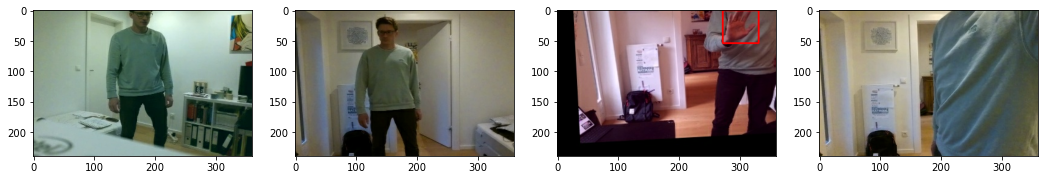

In [610]:
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(18, 12))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    #print(res)
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [360, 240]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [360, 240]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Build neuronal network

## Create NN model

In [617]:
def build_model():
    input_layer = Input(shape=(240, 360, 3))
    
    resized_img = Resizing(120,120)(input_layer)
    rescaled_img = Rescaling(1./255)(resized_img)
    
    vgg = VGG16(include_top=False, pooling='max')
    vgg.trainable = False
    vgg_output = vgg(rescaled_img)
    
    class1 = Dense(2048, activation='relu')(vgg_output)
    class2 = Dense(2, activation='sigmoid')(class1)
    
    regression1 = Dense(2048, activation='relu')(vgg_output)
    regression2 = Dense(4, activation='linear')(regression1) # changed from previously 'sigmoid'
    
    model = Model(inputs=input_layer, outputs=[class2, regression2])
    
    return model

In [618]:
handtracker = build_model()

In [619]:
handtracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 120, 120, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 120, 120, 3)  0           ['resizing[0][0]']               
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['rescaling[0][0]']          

In [620]:
X, y = data_train.as_numpy_iterator().next()

In [621]:
X.shape

(8, 240, 360, 3)

In [622]:
y

(array([[0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1]], dtype=uint8),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.3362573 , 0.10822368, 0.4431652 , 0.31655702],
        [0.        , 0.        , 0.        , 0.        ],
        [0.5041749 , 0.07942296, 0.7351412 , 0.4901586 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.40204677, 0.2864035 , 0.6295687 , 0.7126645 ]], dtype=float32))

In [623]:
classes, coords = handtracker.predict(X)
classes, coords

(array([[0.5598018 , 0.44375744],
        [0.5060182 , 0.5315229 ],
        [0.53335845, 0.5410276 ],
        [0.41469294, 0.5785773 ],
        [0.52022517, 0.4436785 ],
        [0.56526166, 0.4797486 ],
        [0.51513165, 0.5137774 ],
        [0.49145696, 0.529417  ]], dtype=float32),
 array([[ 0.7041192 ,  0.11808984,  0.01144724, -0.3924477 ],
        [ 0.7711355 , -0.27367496,  0.17818852, -0.4314115 ],
        [ 0.3161056 ,  0.2314721 ,  0.20504165, -0.32372314],
        [ 0.73543453,  0.11377107,  0.41422784, -0.666731  ],
        [ 0.5638471 ,  0.06441674,  0.04786909, -0.46444654],
        [ 0.6746762 ,  0.397179  ,  0.13604425, -0.40705407],
        [ 0.6383455 ,  0.30935332,  0.2210213 , -0.6973785 ],
        [ 0.9794059 , -0.24746844,  0.39468   , -0.55501676]],
       dtype=float32))

## Define loss functions

In [624]:
# Define localization loss
def localization_loss(y_true, y_pred):
    """
    Calculates loss function for boundary box. Input needs to be nested list / numpy array with shape (1,4)
    """
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [625]:
# Define loss functions for model
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [626]:
# Test classloss
classloss(y[0], classes).numpy()

0.70545346

In [627]:
# Test regressloss
regressloss(y[1], coords).numpy()

10.386919

## Define model subclass and compile model

In [628]:
class HandTracker(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        
    def compile(self, opt, classloss, regressloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.rloss = regressloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction
            classes, coords = self.model(X, training=True)
            
            # Calculate losses (y vs. prediction)
            batch_closs = self.closs(y[0], classes)
            batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)  # cast can be deleted, once pipeline is rerun
            batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized
            
            # Calculate gradients for trainable variables
            grad = tape.gradient(batch_total_loss, self.model.trainable_variables)
          
        # Change trainable variables in direction of gradient using opt algorithm 
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        # Make a prediction
        classes, coords = self.model(X, training=True)

        # Calculate losses (y vs. prediction) -> no gradient descent!!
        batch_closs = self.closs(y[0], classes)
        batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)  # cast can be deleted, once pipeline is rerun
        batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized

        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [635]:
handtracker = build_model()
model = HandTracker(handtracker)

In [636]:
# Determine optimizer
opt = Adam(0.0001) #, decay=0.00001) # (learning_rate=0.0001, decay=lr_decay) # Make sure Adam is loaded from tensorflow keras!!

In [637]:
model.compile(opt, classloss, regressloss)

## Train model

In [638]:
log_dir = 'logs'

In [639]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [640]:
history = model.fit(data_train, epochs=40, validation_data=data_val, callbacks=[tensorboard_callback])

Epoch 1/40
499/499 [==============================] - 35s 60ms/step - total_loss: 0.8177 - class_loss: 0.2216 - regression_loss: 0.5961 - val_total_loss: 0.3489 - val_class_loss: 0.0845 - val_regression_loss: 0.2644
Epoch 2/40
499/499 [==============================] - 37s 64ms/step - total_loss: 0.2246 - class_loss: 0.0508 - regression_loss: 0.1737 - val_total_loss: 0.0645 - val_class_loss: 0.0060 - val_regression_loss: 0.0585
Epoch 3/40
499/499 [==============================] - 37s 65ms/step - total_loss: 0.2154 - class_loss: 0.0268 - regression_loss: 0.1885 - val_total_loss: 0.0778 - val_class_loss: 0.0079 - val_regression_loss: 0.0699
Epoch 4/40
499/499 [==============================] - 39s 69ms/step - total_loss: 0.1362 - class_loss: 0.0165 - regression_loss: 0.1197 - val_total_loss: 0.2450 - val_class_loss: 0.0537 - val_regression_loss: 0.1912
Epoch 5/40
499/499 [==============================] - 41s 74ms/step - total_loss: 0.1226 - class_loss: 0.0108 - regression_loss: 0.1117 

Epoch 38/40
499/499 [==============================] - 40s 71ms/step - total_loss: 0.0231 - class_loss: 4.4919e-06 - regression_loss: 0.0231 - val_total_loss: 0.0318 - val_class_loss: 0.0000e+00 - val_regression_loss: 0.0318
Epoch 39/40
499/499 [==============================] - 41s 74ms/step - total_loss: 0.0172 - class_loss: 3.5397e-06 - regression_loss: 0.0172 - val_total_loss: 0.0458 - val_class_loss: 2.6400e-04 - val_regression_loss: 0.0455
Epoch 40/40
499/499 [==============================] - 42s 76ms/step - total_loss: 0.0168 - class_loss: 3.5385e-06 - regression_loss: 0.0168 - val_total_loss: 0.0663 - val_class_loss: 4.0213e-06 - val_regression_loss: 0.0663


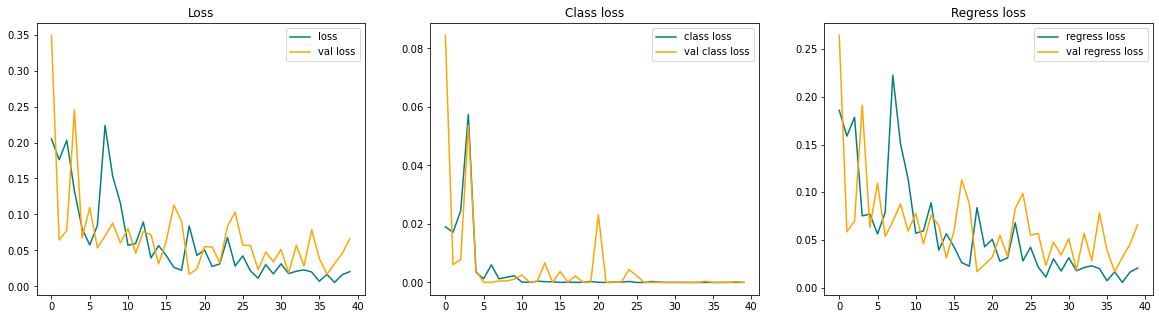

In [641]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Class loss')
ax[1].legend()

ax[2].plot(history.history['regression_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regression_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regress loss')
ax[2].legend()


## Make predictions

In [665]:
handtracker = model.model

In [666]:
data_test_iterator = data_test.as_numpy_iterator()

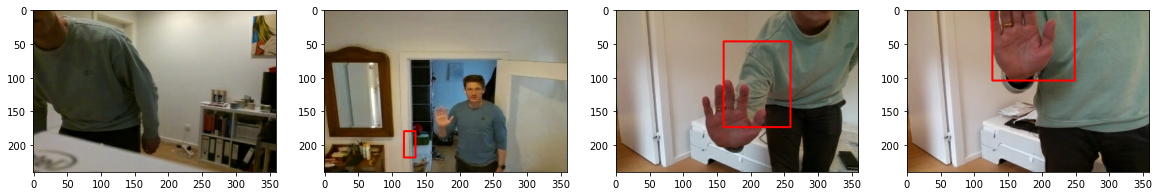

In [672]:
test_sample = data_test_iterator.next()
y_pred = handtracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    
    if y_pred[0][idx, 0] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [360, 240]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [360, 240]).astype(int)),
                      (255,0,0), 2)
        
    ax[idx].imshow(sample_image)

In [551]:
handtracker.save('handtracker.h5')

# Real time detection

In [653]:
from tensorflow.keras.models import load_model

In [654]:
# Load model from h5 file hand_detection_model.ipynbre for testing purposes)
handtracker = load_model('handtracker.h5')

In [6]:
# Image capturing with Tello drone for real time testing

from datetime import datetime, timedelta

me = tello.Tello()
me.connect()
print(me.get_battery())

# Triger stream from drone
me.streamon()

# Initialize variables
datetime_prv = datetime.now() - timedelta(seconds=1)
prob_class_1 = 0

# Start streaming
while True:
    img = me.get_frame_read().frame
    img = cv2.resize(img, (360, 240))
    
    if datetime.now() >= datetime_prv + timedelta(seconds=0.5):
        img_trf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_trf = img_trf.reshape(1, 240, 360, 3)
        y_pred = handtracker.predict(img_trf)
        coords = y_pred[1][0]
        prob_class_1 = y_pred[0][0, 1]
    
    if prob_class_1 > 0.5:
        
        # Draw bbox around hand
        cv2.rectangle(img,
                      tuple(np.multiply(coords[:2], [360, 240]).astype(int)),
                      tuple(np.multiply(coords[2:], [360, 240]).astype(int)),
                      (255,0,0), 2)
        
        # Draw label box
        cv2.rectangle(img,
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [80, 0])),
                      (255,0,0), -1)
        
        # Put text in label
        cv2.putText(img, 'straight_hand', 
                    tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                   
    cv2.imshow("Image", img)
    cv2.waitKey(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

me.streamoff()
cv2.destroyAllWindows()

[INFO] tello.py - 122 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 437 - Send command: 'streamoff'
[INFO] tello.py - 461 - Response streamoff: 'ok'
Exception ignored in: <function Tello.__del__ at 0x111097af0>
Traceback (most recent call last):
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/enforce_types.py", line 54, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1019, in __del__
    self.end()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/enforce_types.py", line 54, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1010, in end
    self.background_frame_read.stop()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1074, in stop
    self.worker.join()
  File "/opt/mi

83


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1065, in update_frame
    self.stop()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1074, in stop
    self.worker.join()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 1050, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
